## Analiza cech wyróżniających gatunek *jazz*

Skrypt filtruje dane tak, aby:
- **`df_target`** zawierał próbki jazzu,
- **`df_rest`** próbki innych gatunków.

Z listy cech numerycznych obliczana jest wartość **d Cohena** dla każdej cechy - miernik różnicy między jazzem a resztą zbioru.  
Na podstawie największych wartości bezwzględnych |d| wybierane jest **TOP 15 cech**, które najlepiej odróżniają jazz.

---

d Cohena to miara wielkości efektu określająca znormalizowaną różnicę średnich między dwiema grupami.

Wzór:

$$
d = \frac{\bar{x}_1 - \bar{x}_2}{s_p}
$$

gdzie:

- średnia w grupie pierwszej  
  $$
  \bar{x}_1
  $$

- średnia w grupie drugiej  
  $$
  \bar{x}_2
  $$

- wspólne odchylenie standardowe (*pooled standard deviation*):

$$
s_p = \sqrt{
\frac{(n_1 - 1)s_1^{2} + (n_2 - 1)s_2^{2}}{n_1 + n_2 - 2}
}
$$

a dodatkowo:

- liczności obu grup  
  $$
  n_1,\; n_2
  $$

- odchylenia standardowe obu grup  
  $$
  s_1,\; s_2
  $$


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Podaj poprawną ścieżkę do plików CSV
df3 = pd.read_csv("lib/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv")
df30 = pd.read_csv("lib/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv")


In [2]:

sns.set(style="whitegrid")


target_genre = "jazz"
label_col = "label"
TOP = 15  # ile top cech chcemy wyświetlić
n_cols = 3  # liczba kolumn w gridzie

# Przygotowanie danych 
df_target = df30[df30[label_col] == target_genre]
df_rest = df30[df30[label_col] != target_genre]

numeric_cols = df30.select_dtypes(include=['float64','int64']).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

#  Cohen's d dla każdej cechy 
results = []
for feat in numeric_cols:
    x1 = df_target[feat].dropna()
    x2 = df_rest[feat].dropna()
    
    mean1, mean2 = x1.mean(), x2.mean()
    std1, std2 = x1.std(), x2.std()
    n1, n2 = len(x1), len(x2)
    
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2)/(n1+n2-2))
    d = (mean1 - mean2)/pooled_std if pooled_std>0 else 0
    
    results.append({"feature": feat, "cohens_d": d})

res_df = pd.DataFrame(results)
res_df["abs_d"] = res_df["cohens_d"].abs()
res_df = res_df.sort_values("abs_d", ascending=False).reset_index(drop=True)

top_features = res_df.head(TOP)["feature"].tolist()
print("Top cechy wyróżniające jazz dla 30s pomiarów:", top_features)

Top cechy wyróżniające jazz dla 30s pomiarów: ['chroma_stft_mean', 'mfcc7_var', 'perceptr_var', 'mfcc1_mean', 'mfcc20_var', 'mfcc6_var', 'rms_mean', 'mfcc19_var', 'mfcc5_var', 'zero_crossing_rate_mean', 'mfcc8_var', 'mfcc4_var', 'mfcc16_var', 'mfcc18_var', 'spectral_centroid_mean']


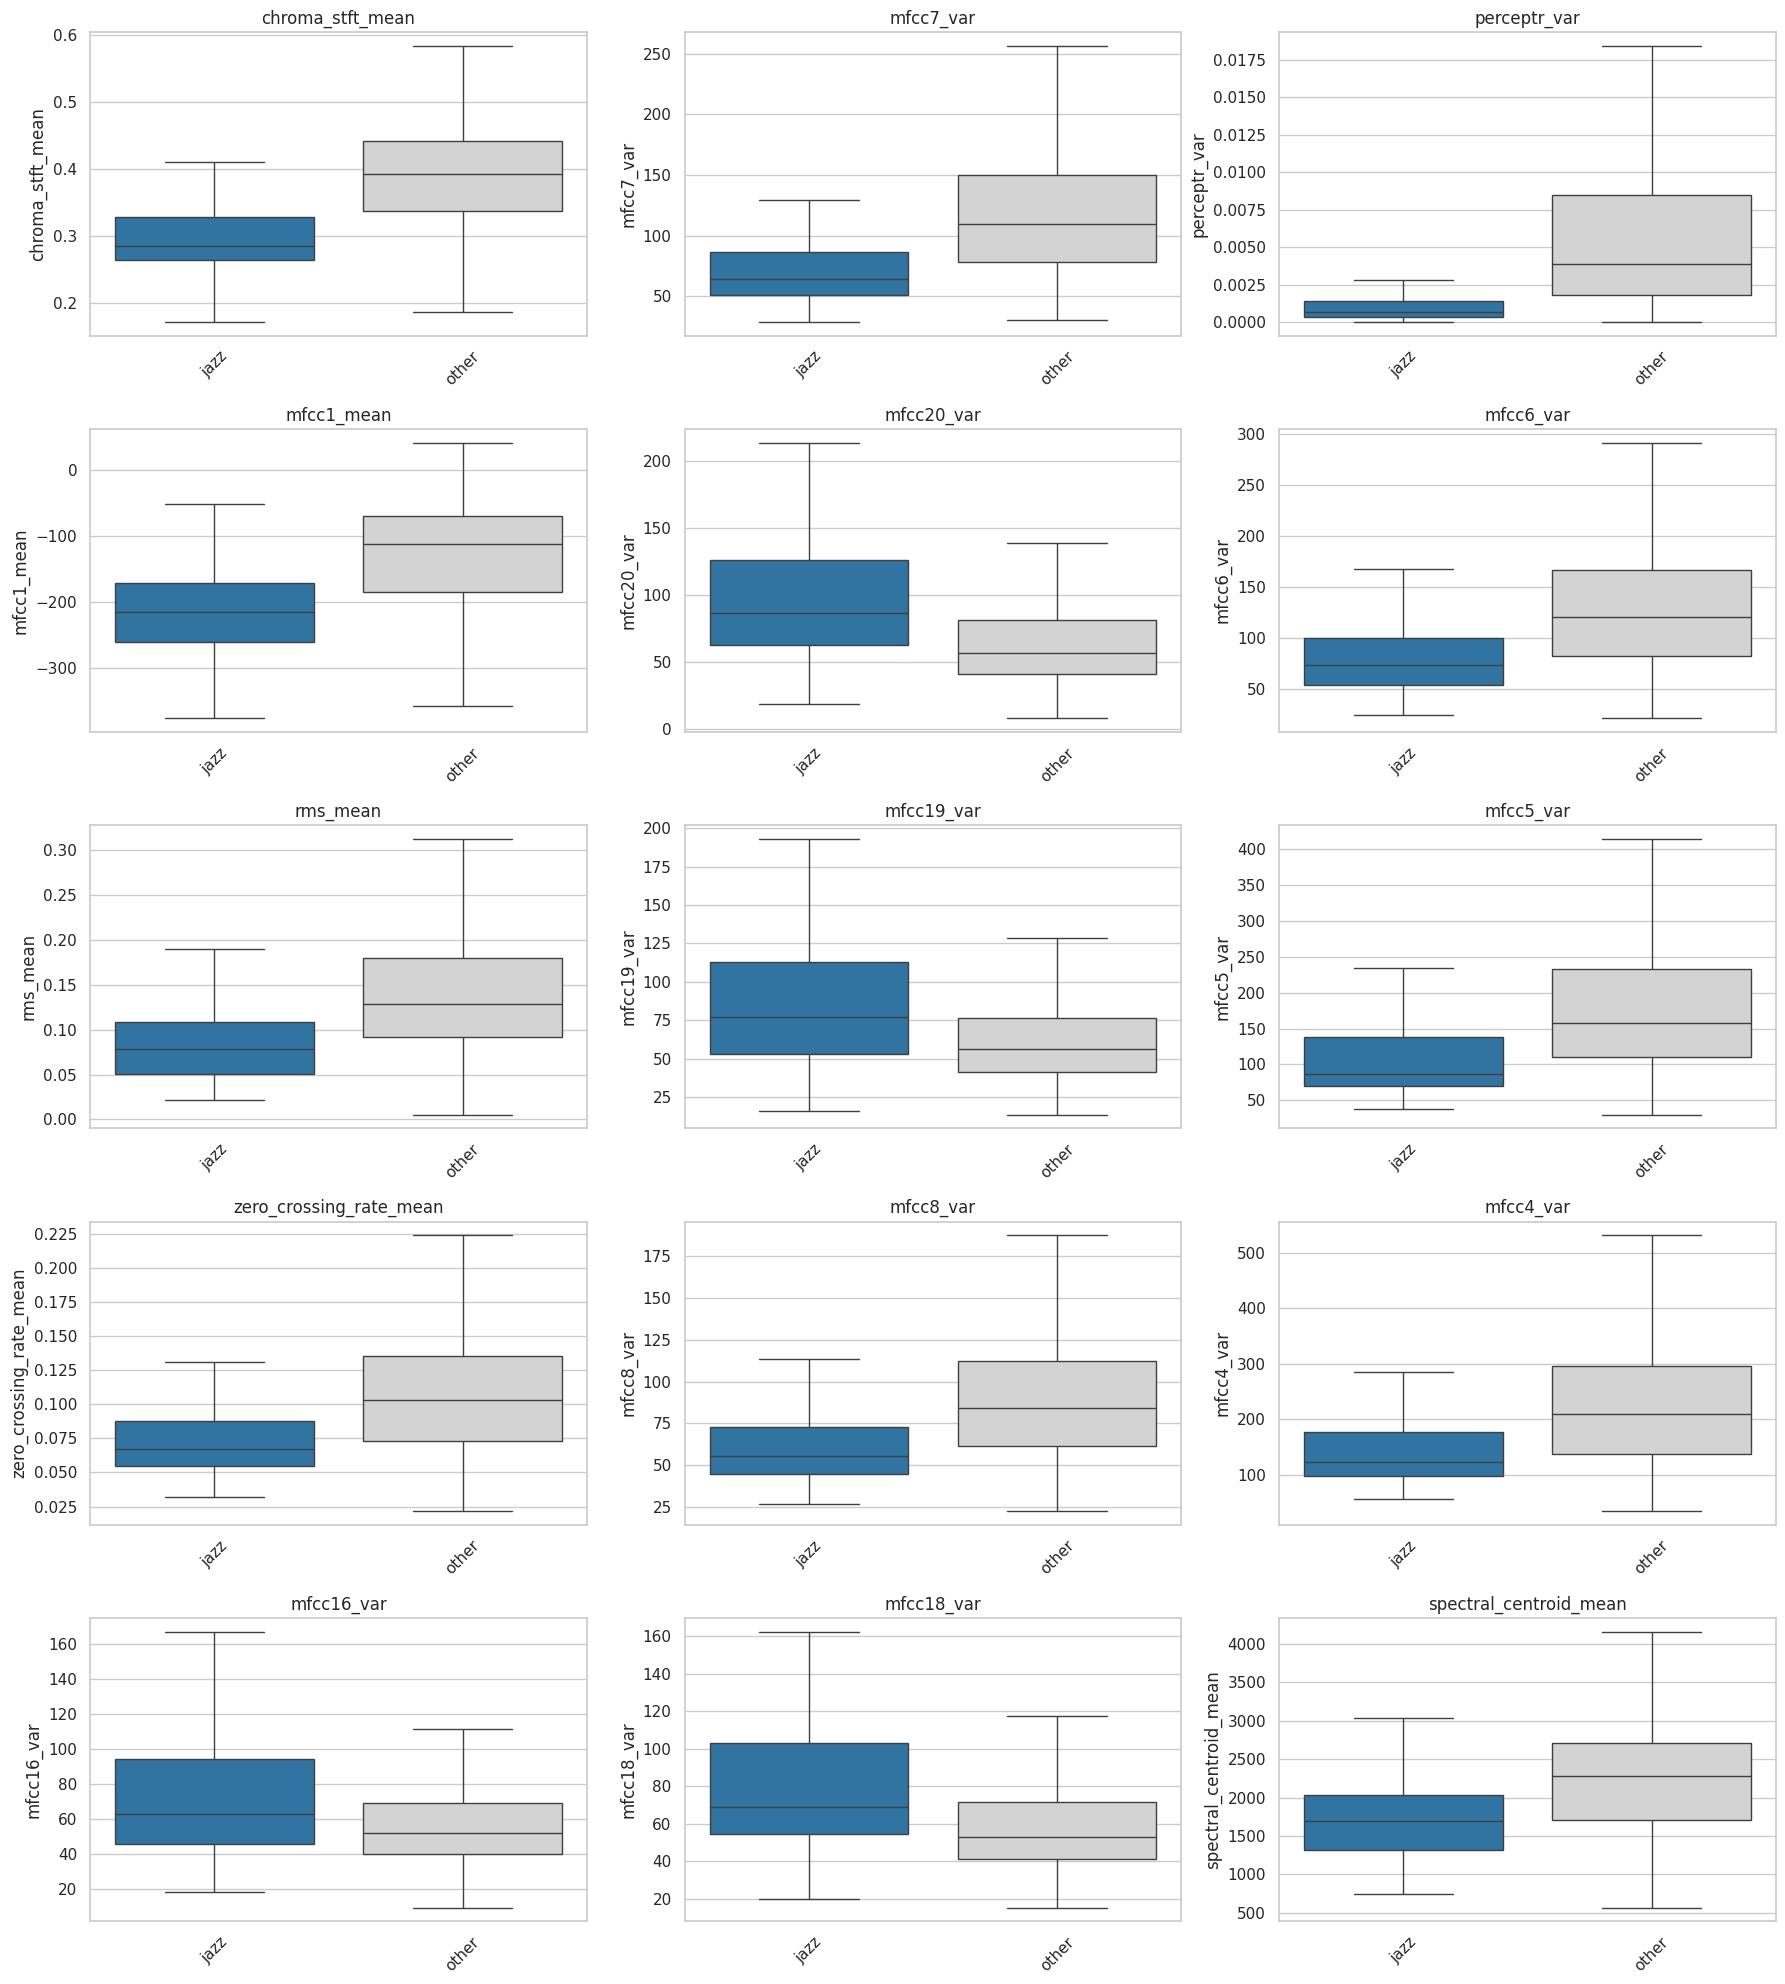

In [3]:

n_rows = int(np.ceil(len(top_features)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

palette_dict = {target_genre: "tab:blue", "other": "lightgrey"}

for i, feat in enumerate(top_features):
    y_values = pd.concat([df_target[feat], df_rest[feat]])
    x_values = [target_genre]*len(df_target) + ["other"]*len(df_rest)
    
    sns.boxplot(
        x=x_values, y=y_values,
        hue=x_values,
        palette=palette_dict,
        showfliers=False,
        ax=axes[i],
        dodge=False,
        legend=False
    )
    
    axes[i].set_title(feat)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import train_test_split

# wybieramy tylko próbki jazzu
target_genre = 'jazz'
df_target = df30[df30['label'] == target_genre]

# dzielimy na dwa zbiory
df_train, df_test = train_test_split(df_target, test_size=0.3, random_state=42)  

#  30 próbek z innych gatunków

df_other = df30[df30['label'] != target_genre]

df_test_other = df_other.sample(
    n=min(30, len(df_other)),
    random_state=42
)

df_test = pd.concat([df_test, df_test_other]).sample(
    frac=1, random_state=42
).reset_index(drop=True)


# obliczamy Q1 i Q3 dla top_features na zbiorze treningowym
quartiles = {}
for feature in top_features:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    quartiles[feature] = {"Q1": Q1, "Q3": Q3}

# konwertujemy na DataFrame dla czytelności
quartiles_df = pd.DataFrame(quartiles).T
print("Q1-Q3 na zbiorze treningowym jazzu:")
print(quartiles_df)

# df_test będzie naszym zbiorem testowym jazzu
print("\nLiczba próbek w zbiorze testowym jazzu:", len(df_test))




Q1-Q3 na zbiorze treningowym jazzu:
                                  Q1           Q3
chroma_stft_mean            0.266524     0.327893
mfcc7_var                  50.635916    83.279331
perceptr_var                0.000316     0.001432
mfcc1_mean               -259.147308  -169.386353
mfcc20_var                 65.150196   103.134455
mfcc6_var                  53.278609    93.482862
rms_mean                    0.049950     0.109772
mfcc19_var                 60.121000   109.178406
mfcc5_var                  70.111601   124.706182
zero_crossing_rate_mean     0.057862     0.094078
mfcc8_var                  44.105989    73.498249
mfcc4_var                  96.872828   172.499645
mfcc16_var                 44.562763    90.438950
mfcc18_var                 54.782160   102.477728
spectral_centroid_mean   1353.023660  2199.620416

Liczba próbek w zbiorze testowym jazzu: 60


In [5]:
def classify_jazz(samples, quartiles_df, features_to_use=None, threshold=7):
    """
    Klasyfikuje próbki jako 'jazz' lub 'other' na podstawie przedziałów Q1–Q3 wybranych cech.

    Args:
        samples (pd.DataFrame lub list[dict]): nowe próbki, kolumny = cechy
        quartiles_df (pd.DataFrame): tabela Q1-Q3 dla jazzu, indeks = nazwa cechy
        features_to_use (list[str], optional): lista cech do uwzględnienia. Domyślnie wszystkie cechy w quartiles_df.
        threshold (int): minimalna liczba cech mieszczących się w Q1-Q3, aby przypisać 'jazz'

    Returns:
        list[str]: lista predykcji dla każdej próbki ('jazz' lub 'other')
    """
    # jeśli lista słowników, konwertujemy na DataFrame
    if isinstance(samples, list):
        samples = pd.DataFrame(samples)
    
    # wybór cech
    if features_to_use is None:
        features = quartiles_df.index.tolist()
    else:
        # upewniamy się, że wybrane cechy są w tabeli kwartylowej
        features = [f for f in features_to_use if f in quartiles_df.index]
    
    predictions = []

    for _, row in samples.iterrows():
        score = 0
        for feat in features:
            if feat in row:
                value = row[feat]
                Q1 = quartiles_df.loc[feat, 'Q1']
                Q3 = quartiles_df.loc[feat, 'Q3']
                if Q1 <= value <= Q3:
                    score += 1
        prediction = 'jazz' if score >= threshold else 'other'
        predictions.append(prediction)
    
    return predictions


In [6]:
df_test_samples = df_test[top_features]
predictions = classify_jazz(df_test_samples, quartiles_df, top_features)


true_labels = ['jazz' if g == 'jazz' else 'other' for g in df_test['label']]

accuracy = sum([p == t for p, t in zip(predictions, true_labels)]) / len(true_labels)

print(f"\nDokładność klasyfikatora na zbiorze testowym jazz + inne: {accuracy:.2f}")


Dokładność klasyfikatora na zbiorze testowym jazz + inne: 0.63


In [7]:
label_col = "label"
def split_by_genre(df, label_col, test_size=0.2, random_state=42):
    train_parts = []
    test_parts = []

    for genre in df[label_col].unique():
        df_genre = df[df[label_col] == genre]

        train_g, test_g = train_test_split(
            df_genre,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )

        train_parts.append(train_g)
        test_parts.append(test_g)

    train_df = pd.concat(train_parts).reset_index(drop=True)
    test_df = pd.concat(test_parts).reset_index(drop=True)

    return train_df, test_df

In [8]:
df3_train, df3_test = split_by_genre(df3, label_col)
df30_train, df30_test = split_by_genre(df30, label_col)


In [9]:
genres_names_df3 = df3.label.unique().tolist()
genres_names_df30 = df30.label.unique().tolist()

genres_df3 = {genre: [] for genre in genres_names_df3}
genres_df30 = {genre: [] for genre in genres_names_df30}

def cohen(generes_list,top_features_quantity = 15, lower = 0.25, upper = 0.75):
    for genres in generes_list:
        for genre in genres:

            df_target = []
            df_rest = []

            if genres is generes_list[0]:
                df_target = df3_train[df3_train[label_col] == genre]
                df_rest   = df3_train[df3_train[label_col] != genre]
            elif genres is generes_list[1]:
                df_target = df30_train[df30_train[label_col] == genre]
                df_rest   = df30_train[df30_train[label_col] != genre]

            current_df = df3_train if genres is generes_list[0] else df30_train
            features_validate = current_df.select_dtypes(include=['float64','int64']).columns.tolist()
            cohen_result = []

            for feat in features_validate:
                x1 = df_target[feat].dropna()
                x2 = df_rest[feat].dropna()

                mean1, mean2 = x1.mean(), x2.mean()
                std1, std2 = x1.std(), x2.std()
                n1, n2 = len(x1), len(x2)

                pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2)/(n1+n2-2))
                d = (mean1 - mean2)/pooled_std if pooled_std > 0 else 0

                cohen_result.append({"feature": feat, "cohens_d": d})

            res_df = pd.DataFrame(cohen_result)
            res_df["abs_d"] = res_df["cohens_d"].abs()
            res_df = res_df.sort_values("abs_d", ascending=False).reset_index(drop=True)

            top_features = res_df.head(top_features_quantity)["feature"].tolist()

            quartiles = {}
            for feature in top_features:
                Q1 = df_target[feature].quantile(lower)
                Q3 = df_target[feature].quantile(upper)
                quartiles[feature] = {"min": Q1, "max": Q3}

            genres.update({genre: quartiles})
cohen([genres_df3,genres_df30])

print('genres 30')
print(genres_df30['jazz'])
print('genres 3')
print(genres_df3['jazz'])


genres 30
{'chroma_stft_mean': {'min': 0.2628917694091797, 'max': 0.3259004652500152}, 'mfcc20_var': {'min': 66.11631393432617, 'max': 126.25426292419434}, 'mfcc7_var': {'min': 51.09662055969238, 'max': 88.83148384094238}, 'mfcc19_var': {'min': 61.3494291305542, 'max': 113.92021369934082}, 'mfcc1_mean': {'min': -260.5299606323242, 'max': -174.30395889282227}, 'perceptr_var': {'min': 0.00031297763052855, 'max': 0.00144983702921305}, 'mfcc5_var': {'min': 71.82592010498047, 'max': 134.98734664916992}, 'mfcc6_var': {'min': 54.9272403717041, 'max': 100.40641784667969}, 'rms_mean': {'min': 0.05012424662709235, 'max': 0.11050833947956559}, 'zero_crossing_rate_mean': {'min': 0.057353598704563004, 'max': 0.08954916398154722}, 'mfcc16_var': {'min': 45.2288703918457, 'max': 91.05488586425781}, 'mfcc8_var': {'min': 46.5849552154541, 'max': 76.37321472167969}, 'mfcc18_var': {'min': 55.87156295776367, 'max': 105.52619934082031}, 'mfcc4_var': {'min': 101.63399314880373, 'max': 187.62740325927734}, 's

## Prosta metoda głosowania - jeśli wpada w przedział gatunku muzycznego + 1 głos. 
## Wygrywa Gatunek muzyczny z największa liczbą głosów.

In [10]:
def score_sample(sample, genre_quartiles):
    score = 0
    for feat, bounds in genre_quartiles.items():
        val = sample.get(feat, None)
        if val is None:
            continue
        if bounds['min'] <= val <= bounds['max']:
            score += 1
    return score

def predict_genre(sample, genres_quartiles):
    scores = {
        genre: score_sample(sample, genres_quartiles[genre])
        for genre in genres_quartiles
    }
    return max(scores, key=scores.get)
def rule_based_predict(df_test, genres_quartiles):
    preds = []
    for _, row in df_test.iterrows():
        preds.append(predict_genre(row, genres_quartiles))
    return preds

def cm_accuracy(cm):
    return 100 * cm.trace() / cm.sum()




In [11]:
genres_df3_5 = {genre: [] for genre in genres_names_df3}
genres_df30_5 = {genre: [] for genre in genres_names_df30}
cohen([genres_df3_5,genres_df30_5],5)

genres_df3_15 = {genre: [] for genre in genres_names_df3}
genres_df30_15 = {genre: [] for genre in genres_names_df30}
cohen([genres_df3_15,genres_df30_15])

genres_df3_30 = {genre: [] for genre in genres_names_df3}
genres_df30_30 = {genre: [] for genre in genres_names_df30}
cohen([genres_df3_30,genres_df30_30],57)



### Wybór odpowiednich parametrów
#### 1. Liczba cech

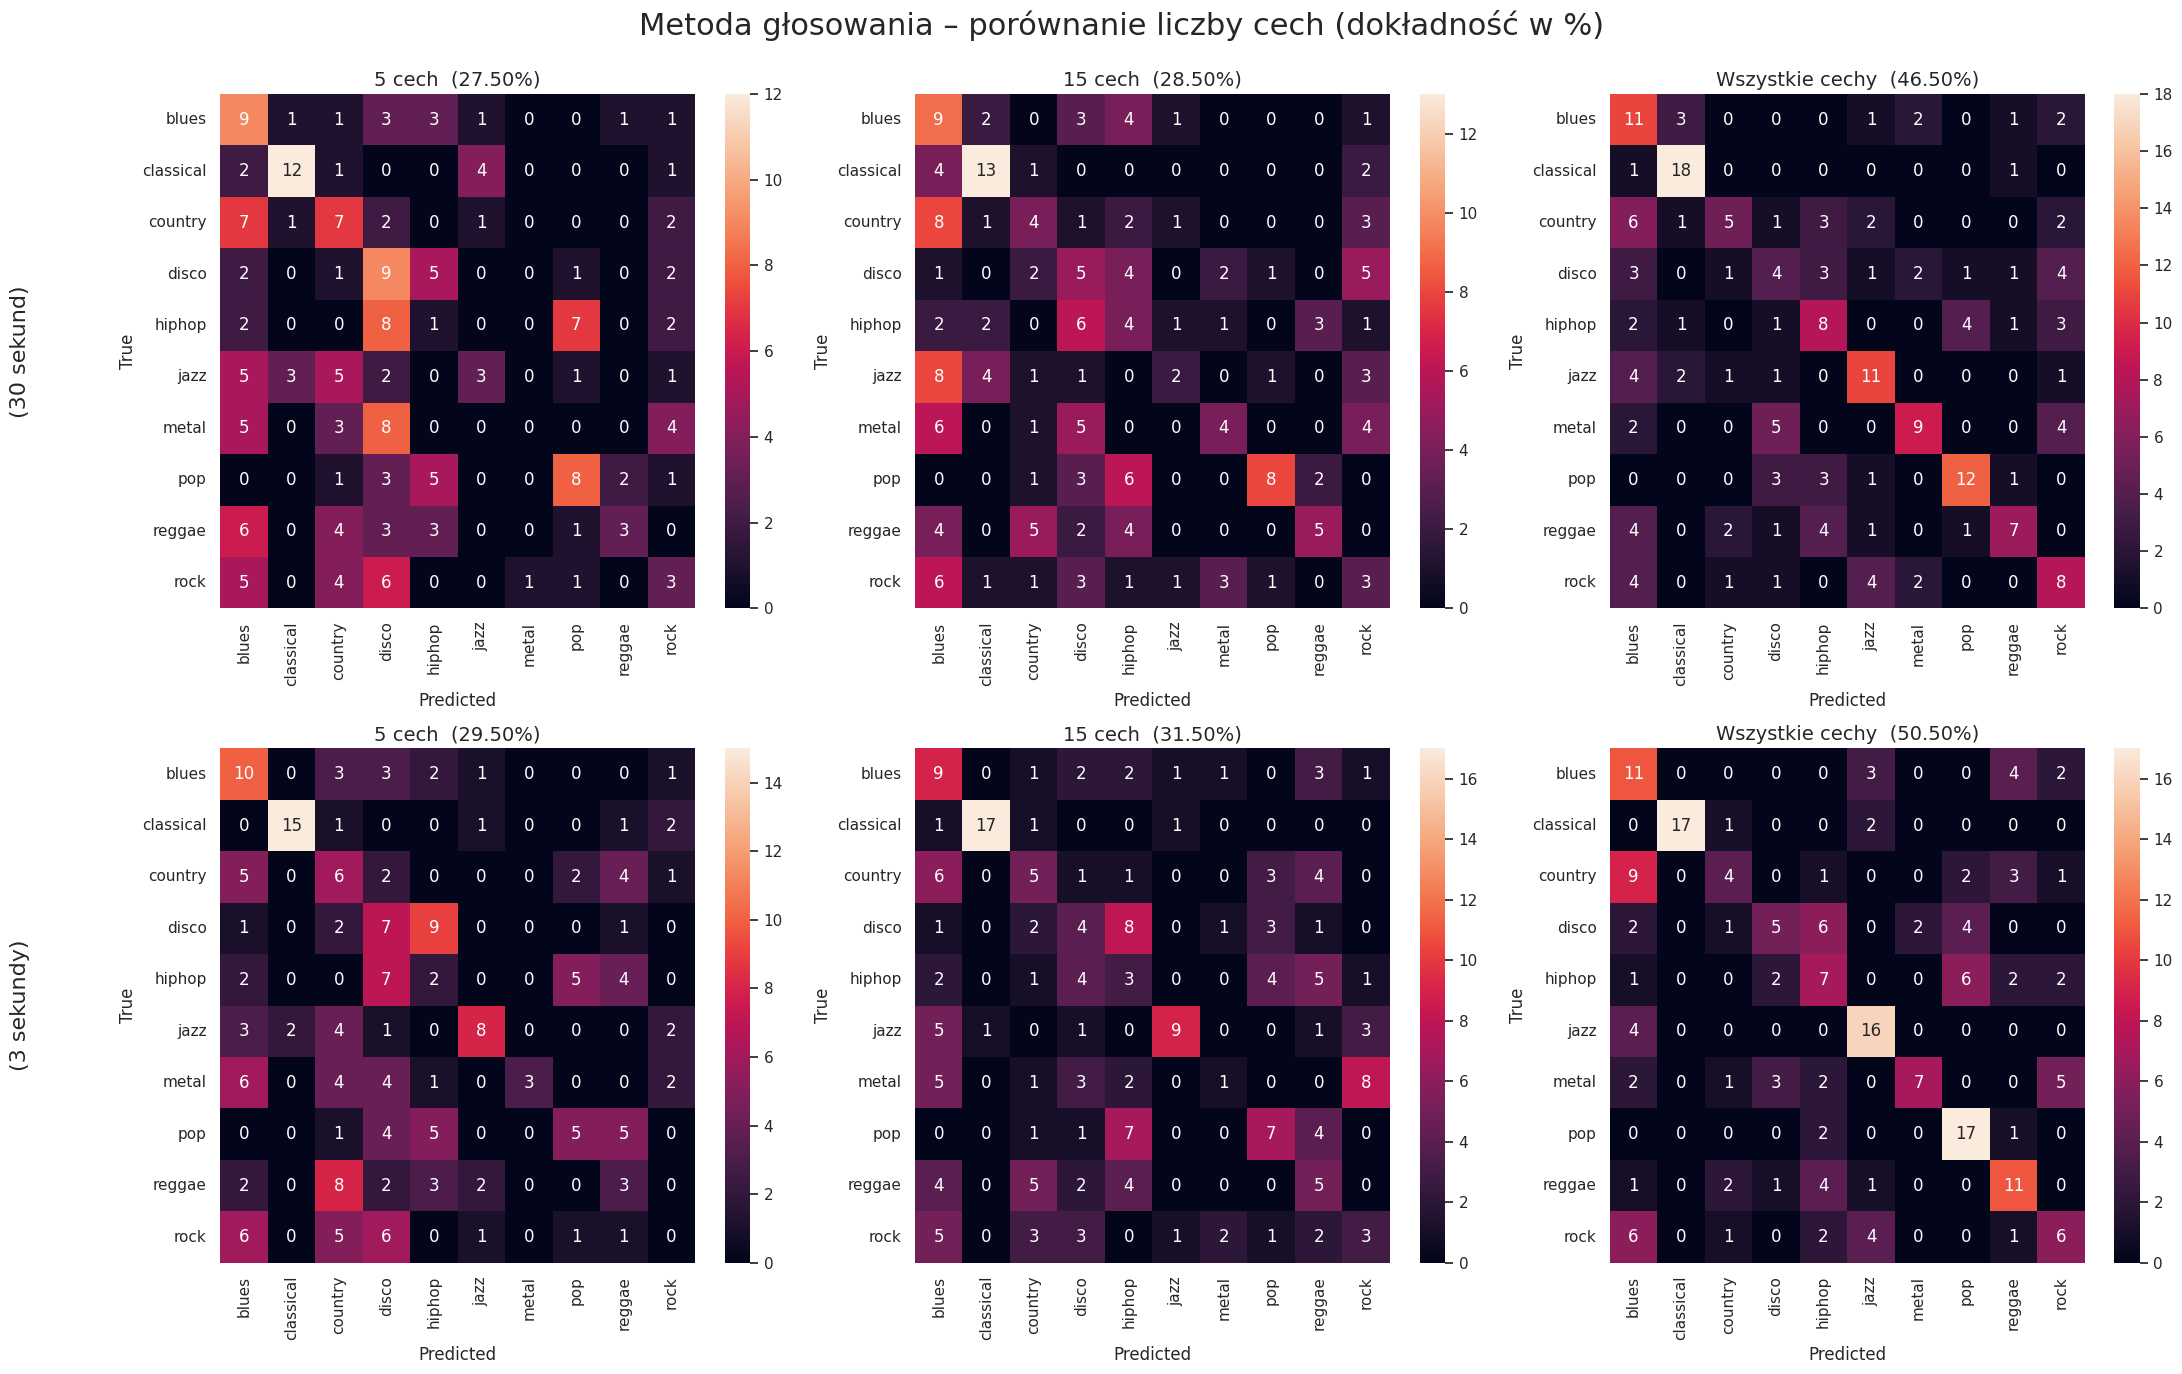

In [12]:
# Predykcje dla różnych zestawów cech
y_pred_30_5  = rule_based_predict(df30_test, genres_df30_5)
y_pred_30_15 = rule_based_predict(df30_test, genres_df30_15)
y_pred_30_30 = rule_based_predict(df30_test, genres_df30_30)

y_pred_3_5   = rule_based_predict(df30_test, genres_df3_5)
y_pred_3_15  = rule_based_predict(df30_test, genres_df3_15)
y_pred_3_30  = rule_based_predict(df30_test, genres_df3_30)

y_true_30 = df30_test[label_col]
labels = sorted(df30_test[label_col].unique())

# Macierze pomyłek
cm_rule_30_5   = confusion_matrix(y_true_30, y_pred_30_5,  labels=labels)
cm_rule_30_15  = confusion_matrix(y_true_30, y_pred_30_15, labels=labels)
cm_rule_30_30  = confusion_matrix(y_true_30, y_pred_30_30, labels=labels)

cm_rule_3_5    = confusion_matrix(y_true_30, y_pred_3_5,   labels=labels)
cm_rule_3_15   = confusion_matrix(y_true_30, y_pred_3_15,  labels=labels)
cm_rule_3_30   = confusion_matrix(y_true_30, y_pred_3_30,  labels=labels)

# Tworzymy siatkę 2 wiersze x 3 kolumny
fig, axes = plt.subplots(2, 3, figsize=(22, 14))

cms = [
    [cm_rule_30_5, cm_rule_30_15, cm_rule_30_30],  # DF30
    [cm_rule_3_5,  cm_rule_3_15,  cm_rule_3_30]    # DF3
]

titles = ["5 cech", "15 cech", "Wszystkie cechy"]
row_labels = ["(30 sekund)", "(3 sekundy)"]

for row in range(2):
    for col in range(3):
        acc = cm_accuracy(cms[row][col])

        sns.heatmap(
            cms[row][col],
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels,
            ax=axes[row, col]
        )

        axes[row, col].set_title(
            f"{titles[col]}  ({acc:.2f}%)",
            fontsize=14
        )
        axes[row, col].set_xlabel("Predicted")
        axes[row, col].set_ylabel("True")

    # Etykieta wiersza
    axes[row, 0].text(
        -0.4, 0.5, row_labels[row],
        rotation=90,
        fontsize=16,
        va='center',
        ha='right',
        transform=axes[row, 0].transAxes
    )

# Duży wspólny tytuł
fig.suptitle(
    "Metoda głosowania – porównanie liczby cech (dokładność w %)",
    fontsize=22
)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Wnioski:
#### Wraz z wzrostem liczby wybranych cech rośnie prawidłowa klasyfikacja z wyjątkiem Country i Disco 
#### Najbardziej opytmalnie jest wybrać wszystkie cechy
#### Najłatwiej sklasyfikować muzykę klasyczną
#### Najczęściej gdy błąd wynika z tego, że utwór jest klasyfikowany jako blues

#### Uzyskano maksymalnie 46.5% poprawności na fragmentach 30s i 50.5% na 3s

In [13]:
genres_df3_5 = {genre: [] for genre in genres_names_df3}
genres_df30_5 = {genre: [] for genre in genres_names_df30}
cohen([genres_df3_5,genres_df30_5],57,0.4,0.6)

genres_df3_15 = {genre: [] for genre in genres_names_df3}
genres_df30_15 = {genre: [] for genre in genres_names_df30}
cohen([genres_df3_15,genres_df30_15],57,0.1,0.9)

genres_df3_30 = {genre: [] for genre in genres_names_df3}
genres_df30_30 = {genre: [] for genre in genres_names_df30}
cohen([genres_df3_30,genres_df30_30],57,0.01,0.99)


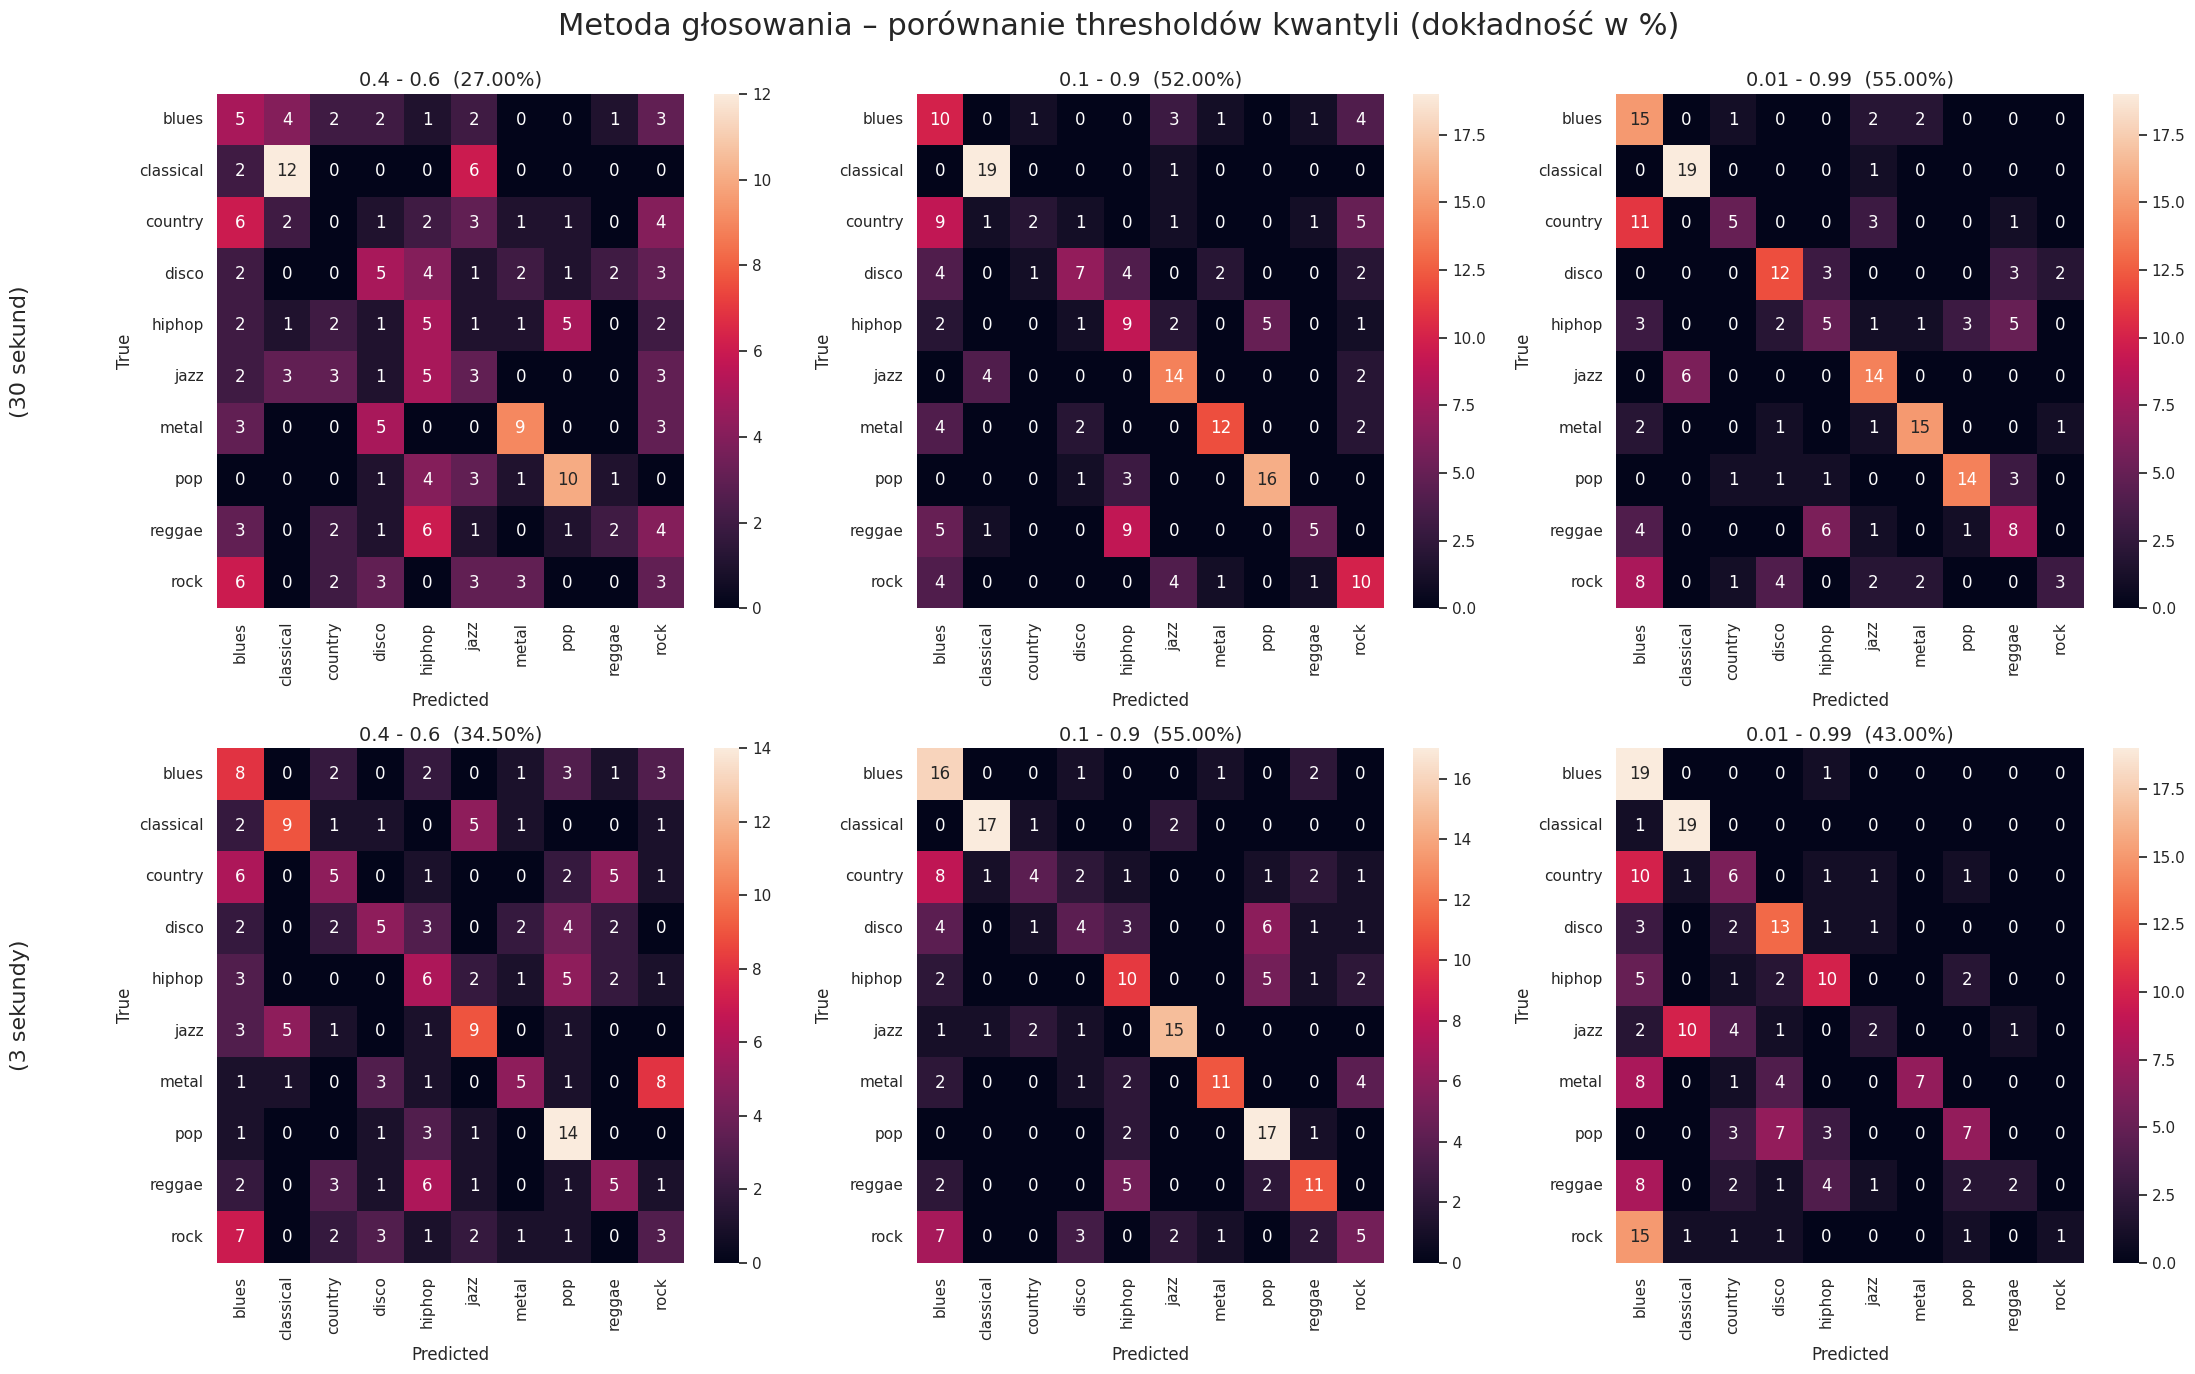

In [14]:
# Predykcje dla różnych zestawów cech
y_pred_30_5  = rule_based_predict(df30_test, genres_df30_5)
y_pred_30_15 = rule_based_predict(df30_test, genres_df30_15)
y_pred_30_30 = rule_based_predict(df30_test, genres_df30_30)

y_pred_3_5   = rule_based_predict(df30_test, genres_df3_5)
y_pred_3_15  = rule_based_predict(df30_test, genres_df3_15)
y_pred_3_30  = rule_based_predict(df30_test, genres_df3_30)

y_true_30 = df30_test[label_col]
labels = sorted(df30_test[label_col].unique())

# Macierze pomyłek
cm_rule_30_5   = confusion_matrix(y_true_30, y_pred_30_5,  labels=labels)
cm_rule_30_15  = confusion_matrix(y_true_30, y_pred_30_15, labels=labels)
cm_rule_30_30  = confusion_matrix(y_true_30, y_pred_30_30, labels=labels)

cm_rule_3_5    = confusion_matrix(y_true_30, y_pred_3_5,   labels=labels)
cm_rule_3_15   = confusion_matrix(y_true_30, y_pred_3_15,  labels=labels)
cm_rule_3_30   = confusion_matrix(y_true_30, y_pred_3_30,  labels=labels)

# Tworzymy siatkę 2 wiersze x 3 kolumny
fig, axes = plt.subplots(2, 3, figsize=(22, 14))

cms = [
    [cm_rule_30_5, cm_rule_30_15, cm_rule_30_30],  # DF30
    [cm_rule_3_5,  cm_rule_3_15,  cm_rule_3_30]    # DF3
]

titles = ["0.4 - 0.6", "0.1 - 0.9", "0.01 - 0.99"]
row_labels = ["(30 sekund)", "(3 sekundy)"]

for row in range(2):
    for col in range(3):
        acc = cm_accuracy(cms[row][col])

        sns.heatmap(
            cms[row][col],
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels,
            ax=axes[row, col]
        )

        axes[row, col].set_title(
            f"{titles[col]}  ({acc:.2f}%)",
            fontsize=14
        )
        axes[row, col].set_xlabel("Predicted")
        axes[row, col].set_ylabel("True")

    # Etykieta wiersza
    axes[row, 0].text(
        -0.4, 0.5, row_labels[row],
        rotation=90,
        fontsize=16,
        va='center',
        ha='right',
        transform=axes[row, 0].transAxes
    )

# Duży wspólny tytuł
fig.suptitle(
    "Metoda głosowania – porównanie thresholdów kwantyli (dokładność w %)",
    fontsize=22
)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Wnioski:
### Największym problemem jest zbyt częste przypisywanie do kategorii blues 
### Potrzebujemy znaleźć sposób aby odseparować country,rock  od bluesa 
### Zmieniając parametry udało się podwyższyć % skuteczności do 55%